In [595]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

- Raw counts: Vehicle counts recorded at this count point
- Count points	Count point in London details

In [597]:
df_merged = pd.read_csv("df_clean.csv")

In [598]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414252 entries, 0 to 414251
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   count_point_id                414252 non-null  int64  
 1   direction_of_travel           414252 non-null  object 
 2   year                          414252 non-null  int64  
 3   count_date                    414252 non-null  object 
 4   hour                          414252 non-null  int64  
 5   region_id_raw                 414252 non-null  int64  
 6   region_name_raw               414252 non-null  object 
 7   local_authority_id_raw        414252 non-null  int64  
 8   local_authority_name_raw      414252 non-null  object 
 9   road_name_raw                 414252 non-null  object 
 10  road_type_raw                 414252 non-null  object 
 11  easting_raw                   414252 non-null  int64  
 12  northing_raw                  414252 non-nul

# Feature Engineering

In [600]:
df_merged['datetime'] = pd.to_datetime(df_merged['count_date'] + ' ' + df_merged['hour'].astype(str) + ':00:00')

In [601]:
vehicle_columns = ['pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 
                   'buses_and_coaches', 'lgvs', 'all_hgvs']

df_merged['total_volume'] = df_merged[vehicle_columns].sum(axis=1)

Total Volume column by summing all vehicle types

In [603]:
df_merged['hour_of_day'] = df_merged['datetime'].dt.hour
df_merged['day_of_week'] = df_merged['datetime'].dt.dayofweek # Monday=0 to Sunday=6
df_merged['is_weekend'] = df_merged['day_of_week'].isin([5, 6]).astype(int)
df_merged['month'] = df_merged['datetime'].dt.month
df_merged['year'] = df_merged['datetime'].dt.year

Time-based features

In [605]:
drop_columns = [
    'count_point_id',
    
    'all_motor_vehicles', 'all_hgvs',
    
    'region_name_raw', 'local_authority_name_raw', "region_id_raw",
    'road_name_raw', 'road_type_raw',
    'count_date', 'datetime', "is_weekend", "hour_of_day", "total_volume"
]
df_merged = df_merged.drop(drop_columns, axis=1)

In [606]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414252 entries, 0 to 414251
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   direction_of_travel           414252 non-null  object 
 1   year                          414252 non-null  int32  
 2   hour                          414252 non-null  int64  
 3   local_authority_id_raw        414252 non-null  int64  
 4   easting_raw                   414252 non-null  int64  
 5   northing_raw                  414252 non-null  int64  
 6   latitude_raw                  414252 non-null  float64
 7   longitude_raw                 414252 non-null  float64
 8   link_length_km_raw            414252 non-null  float64
 9   link_length_miles_raw         414252 non-null  float64
 10  pedal_cycles                  414252 non-null  int64  
 11  two_wheeled_motor_vehicles    414252 non-null  int64  
 12  cars_and_taxis                414252 non-nul

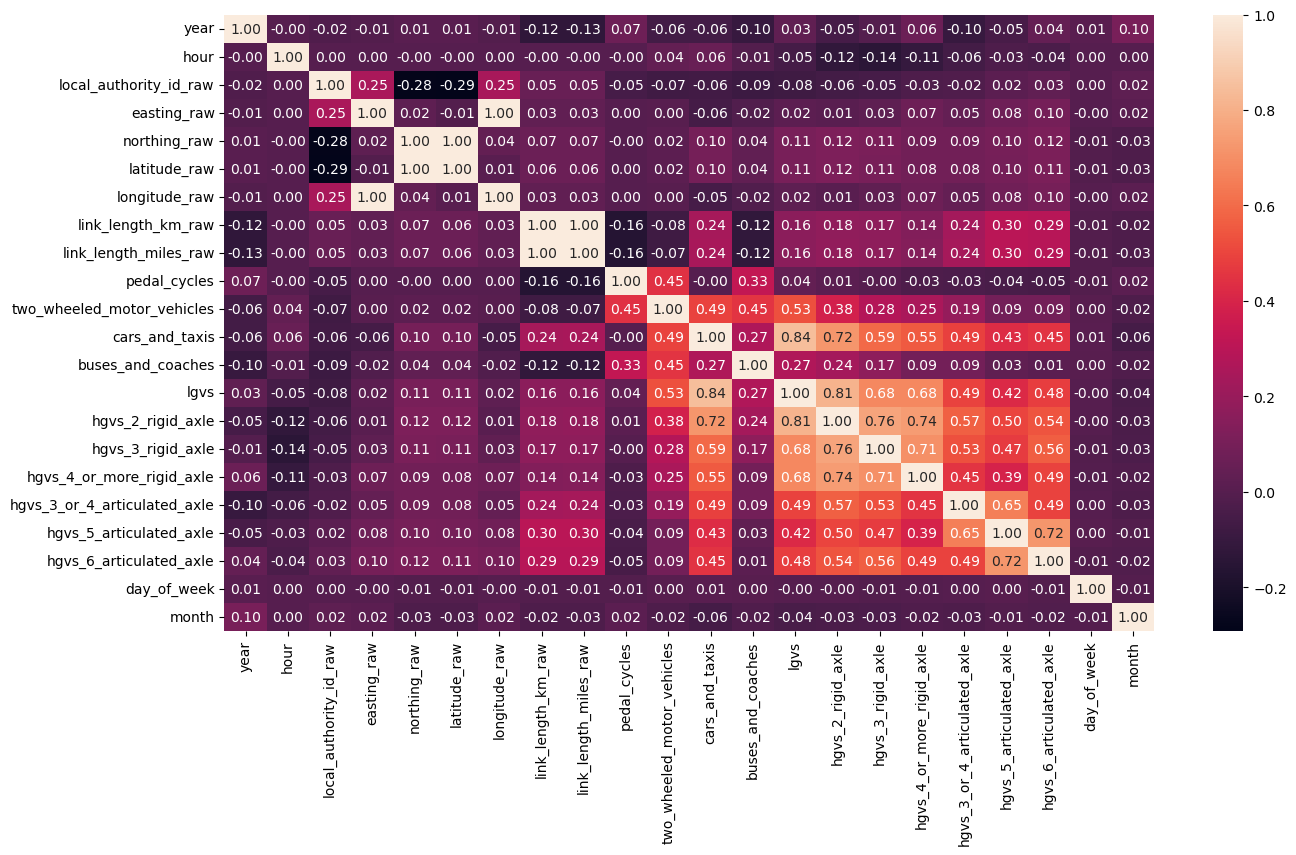

In [607]:
plt.figure(figsize=(15,8))
sns.heatmap(df_merged.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()

- lgvs and cars_and_taxis
- lgvs and hgvs_2_rigid_axle

# Review 2

## Preprocessing

In [611]:
df_model = df_merged[df_merged.year > 2021]

In [612]:
df_model.shape

(33504, 23)

### Target Variables

In [613]:
X = df_model.drop(["cars_and_taxis"], axis=1)

y_reg = df_model[['cars_and_taxis']]

In [614]:
median_cars = df_model['cars_and_taxis'].median()

df_model['traffic_level'] = (df_model['cars_and_taxis'] > median_cars).astype(int)
y_clf = df_model['traffic_level']

C:\Users\91741\AppData\Local\Temp\ipykernel_8536\2711488051.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['traffic_level'] = (df_model['cars_and_taxis'] > median_cars).astype(int)


In [615]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

categorical_features = ['direction_of_travel']
numerical_features = [col for col in X.columns if col not in categorical_features]

print(categorical_features)
print(numerical_features)

['direction_of_travel']
['year', 'hour', 'local_authority_id_raw', 'easting_raw', 'northing_raw', 'latitude_raw', 'longitude_raw', 'link_length_km_raw', 'link_length_miles_raw', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle', 'hgvs_3_rigid_axle', 'hgvs_4_or_more_rigid_axle', 'hgvs_3_or_4_articulated_axle', 'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle', 'day_of_week', 'month']


### Label Encoding

In [617]:
le = LabelEncoder()

In [618]:
print(X.direction_of_travel.unique())

X['new_direction_of_travel'] = le.fit_transform(X['direction_of_travel'])
print(X.new_direction_of_travel.unique())
X.drop(['direction_of_travel'], inplace=True, axis=1)

['E' 'W' 'N' 'S']
[0 3 1 2]


### Splitting

In [620]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

### Scaling

In [621]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Regression Models

### Linear, SVM, DT, RF,AB,ANN

In [622]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [623]:
lr = LinearRegression()
svr = SVR(kernel="rbf")
dtr = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
ada = AdaBoostRegressor(random_state=42)
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000)

In [624]:
regression_results = {}

## Linear Regression

In [626]:
lr.fit(X_train, y_train)

y_pred1 = lr.predict(X_test)
    
mse1 = mean_squared_error(y_test, y_pred1)
rmse1 = np.sqrt(mse1)
r2_1 = r2_score(y_test, y_pred1)
    
regression_results["Linear Regression"] = {'RMSE': rmse1, 'R2': r2_1, 'mse': mse1}
    
print(f"Linear Regression: RMSE = {rmse1:.2f}, R2 = {r2_1:.4f}")

Linear Regression: RMSE = 297.06, R2 = 0.8330


## Support Vector Machine

In [628]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

svr = SVR(kernel='rbf', C=0.5, tol=1e-2, max_iter=5000)

svr.fit(X_train, y_train)
y_pred2 = svr.predict(X_test)

mse2 = mean_squared_error(y_test, y_pred2)
rmse2 = np.sqrt(mse2)
r2_2 = r2_score(y_test, y_pred2)

regression_results["SVM"] = {'RMSE': rmse2, 'R2': r2_2, 'mse': mse2}

print(f"SVM: RMSE = {rmse2:.3f}, R2 = {r2_2:.4f}")

C:\Users\91741\anaconda3\envs\pytorch_vision\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\91741\anaconda3\envs\pytorch_vision\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: RMSE = 577.387, R2 = 0.3689


## Decision Tree Regression

In [630]:
dtr.fit(X_train, y_train)

y_pred3 = dtr.predict(X_test)
    
mse3 = mean_squared_error(y_test, y_pred3)
rmse3 = np.sqrt(mse3)
r2_3 = r2_score(y_test, y_pred3)
    
regression_results["Decision Tree"] = {'RMSE': rmse3, 'R2': r2_3, 'mse': mse3}
    
print(f"Linear Regression: RMSE = {rmse3:.3f}, R2 = {r2_3:.4f}")

Linear Regression: RMSE = 200.353, R2 = 0.9240


## Random Forest Regression

In [632]:
rf.fit(X_train, y_train)

y_pred4 = rf.predict(X_test)
    
mse4 = mean_squared_error(y_test, y_pred4)
rmse4 = np.sqrt(mse4)
r2_4 = r2_score(y_test, y_pred4)
    
regression_results["Random Forest"] = {'RMSE': rmse4, 'R2': r2_4, 'mse': mse4}
    
print(f"Linear Regression: RMSE = {rmse4:.3f}, R2 = {r2_4:.4f}")

C:\Users\91741\anaconda3\envs\pytorch_vision\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Linear Regression: RMSE = 131.854, R2 = 0.9671


## AdaBoost Regression

In [634]:
ada.fit(X_train, y_train)

y_pred5 = ada.predict(X_test)
    
mse5 = mean_squared_error(y_test, y_pred5)
rmse5 = np.sqrt(mse5)
r2_5 = r2_score(y_test, y_pred5)
    
regression_results["AdaBoost"] = {'RMSE': rmse5, 'R2': r2_5, 'mse': mse5}
    
print(f"Linear Regression: RMSE = {rmse5:.3f}, R2 = {r2_5:.4f}")

C:\Users\91741\anaconda3\envs\pytorch_vision\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear Regression: RMSE = 394.604, R2 = 0.7052


## Multilayer Perceptron

In [636]:
mlp.fit(X_train, y_train)

y_pred6 = mlp.predict(X_test)
    
mse6 = mean_squared_error(y_test, y_pred6)
rmse6 = np.sqrt(mse6)
r2_6 = r2_score(y_test, y_pred6)
    
regression_results["MLP"] = {'RMSE': rmse6, 'R2': r2_6, 'mse': mse6}
    
print(f"Linear Regression: RMSE = {rmse6:.3f}, R2 = {r2_6:.4f}")

C:\Users\91741\anaconda3\envs\pytorch_vision\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear Regression: RMSE = 127.762, R2 = 0.9691


# Classification Models
### Logistic,SVM, DT, RF,AB,ANN

In [702]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

In [703]:
X_train_scaled_clf = sc.fit_transform(X_train_clf)
X_test_scaled_clf = sc.transform(X_test_clf)

X_train_clf = pd.DataFrame(X_train_scaled_clf, columns=X_train_clf.columns, index=X_train_clf.index)
X_test_clf = pd.DataFrame(X_test_scaled_clf, columns=X_test_clf.columns, index=X_test_clf.index)

In [704]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [705]:
classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(kernel='rbf', C=0.5, tol=1e-2, max_iter=5000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000)
}

classification_results = {}

In [706]:
for name, model in classification_models.items():
    print(f"Training {name}...")
    model.fit(X_train_clf, y_train_clf)
    y_pred = model.predict(X_test_clf)
    
    accuracy = accuracy_score(y_test_clf, y_pred)
    precision = precision_score(y_test_clf, y_pred)
    recall = recall_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred)
    
    classification_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    
    print(f"{name}: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")

Training Logistic Regression...
Logistic Regression: Accuracy = 0.8970, F1 = 0.8951
Training SVM...


C:\Users\91741\anaconda3\envs\pytorch_vision\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: Accuracy = 0.9275, F1 = 0.9271
Training Decision Tree...
Decision Tree: Accuracy = 0.9103, F1 = 0.9104
Training Random Forest...
Random Forest: Accuracy = 0.9509, F1 = 0.9512
Training AdaBoost...


C:\Users\91741\anaconda3\envs\pytorch_vision\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost: Accuracy = 0.9188, F1 = 0.9196
Training Neural Network...
Neural Network: Accuracy = 0.9452, F1 = 0.9444


# Visualize Metrics

In [708]:
reg_df = pd.DataFrame(regression_results).T
clf_df = pd.DataFrame(classification_results).T

### Regression Metrics

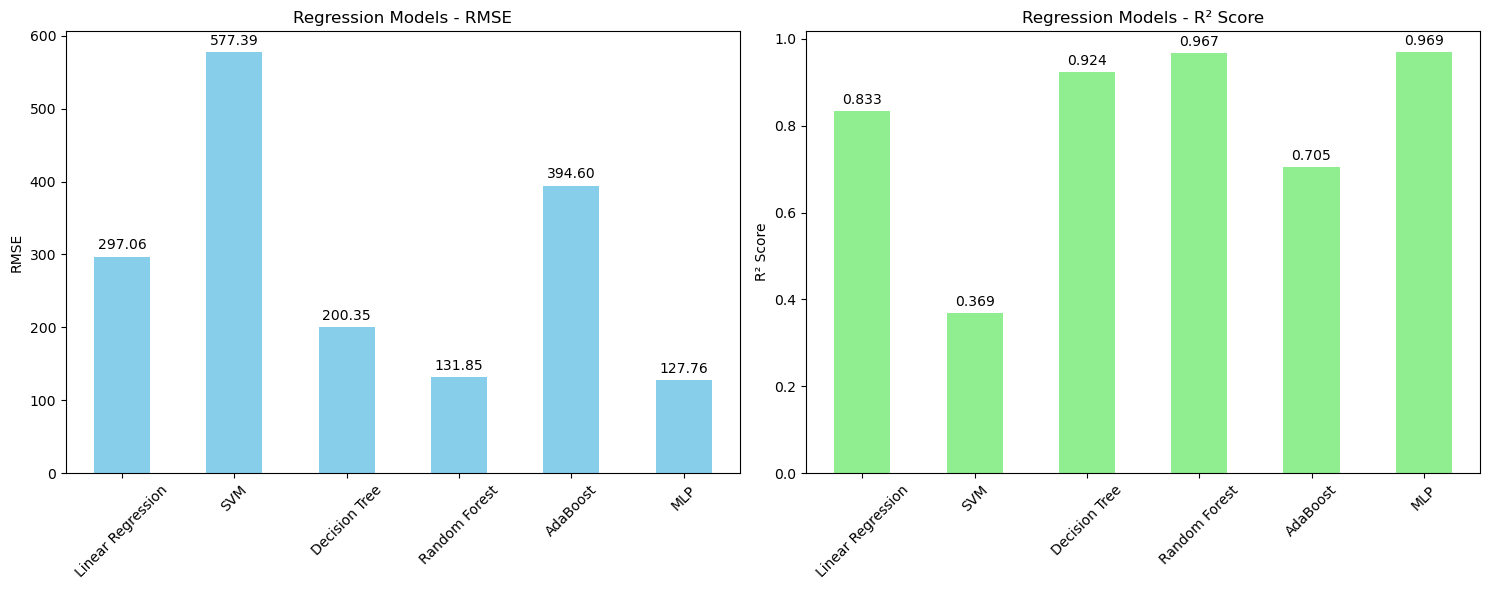

In [710]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

reg_df['RMSE'].plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Regression Models - RMSE')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=10)

    
reg_df['R2'].plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Regression Models - R² Score')
ax2.set_ylabel('R² Score')
ax2.tick_params(axis='x', rotation=45)

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f', label_type='edge', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

### Classification Metrics

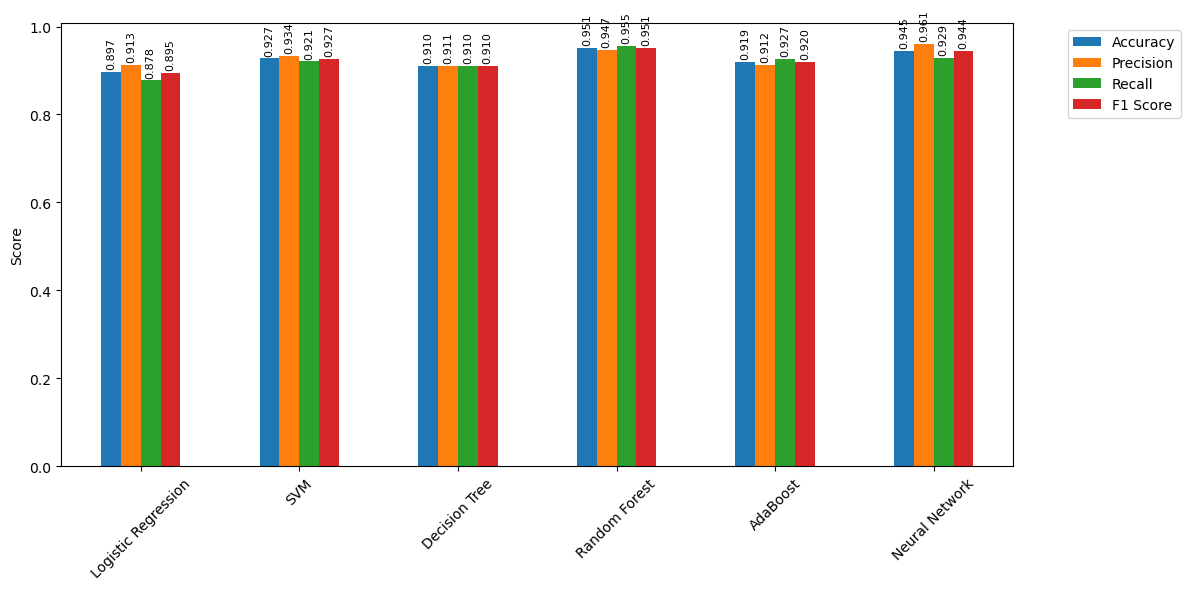

In [727]:
fig, ax = plt.subplots(figsize=(12, 6))
bars = clf_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=ax)

#ax.set_title('Classification Models - Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.tick_params(axis='x', rotation=45)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=2, fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

# Multilayer Perceptron has the best regression metrics
# Random Forest has the best classification metrics

### Tabulate Results

In [715]:
reg_df.to_csv("Regression Metrics.csv")
clf_df.to_csv("Classification Metrics.csv")